In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
# from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
# import gribscan
import intake
import sys
sys.path.append("../")
import nextgems as ng

In [3]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [4]:
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3']))

['2D_1h_native', '3D_1h6h_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', 'WAM_1h_native']


In [6]:
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['3D_1h6h_native'].to_dask()

In [5]:
lon_start = -70
lat_start = 32
lon_end = -70
lat_end = 37
npoints   = 100
lonlat = ng.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

In [9]:
ifs_lon = np.where(ds.lon.values > 180, ds.lon.values - 360, ds.lon.values)
ifs_lat = ds.lat.values

In [10]:
nodes = ng.transect_get_nodes(lonlat, ifs_lon, ifs_lat)

In [12]:
dist = ng.transect_get_distance(lonlat)

In [21]:
as_data = ds['q'][6,:,:].values[:, nodes]

In [15]:
import matplotlib.pylab as plt
import matplotlib.cm as cm

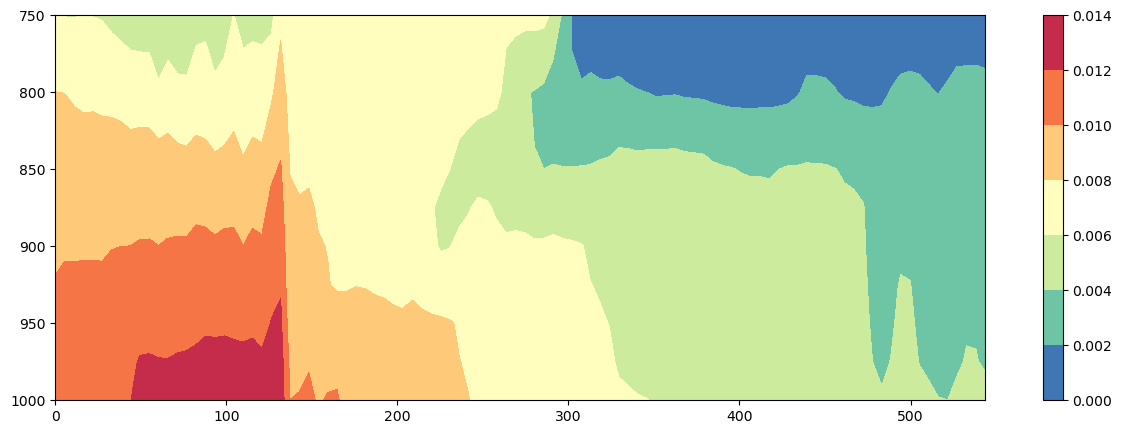

In [22]:
plt.figure(figsize=(15,5))
ax = plt.gca()
im = ax.contourf(dist, ds['t'].level.values[3:], as_data[3:,:], 
                 # levels=np.linspace(264,295,30), 
                 cmap=cm.Spectral_r)
ax.invert_yaxis()
plt.colorbar(im)

In [20]:
print(list(cat.FESOM['IFS_4.4-FESOM_5-cycle3']))

['2D_1h_0.25deg', '2D_1h_1deg', '2D_1h_native', '2D_daily_0.25deg', '2D_daily_1deg', '2D_daily_native', '2D_monthly_0.25deg', '2D_monthly_1deg', '2D_monthly_native', '3D_1h_native_zarr', '3D_3h_native', '3D_daily_native', '3D_daily_native_zarr', 'elem_grid', 'node_grid']


In [23]:
ocean = cat.FESOM['IFS_4.4-FESOM_5-cycle3']['3D_3h_native'].to_dask()

In [24]:
ocean_mesh = cat.FESOM['IFS_4.4-FESOM_5-cycle3']['node_grid'].to_dask()

In [25]:
nodes_ocean = ng.transect_get_nodes(lonlat, ocean_mesh.grid_center_lon.values, ocean_mesh.grid_center_lat.values)

In [28]:
oc_data = ocean['temp_upper'][1,:,:].values[:,nodes_ocean]

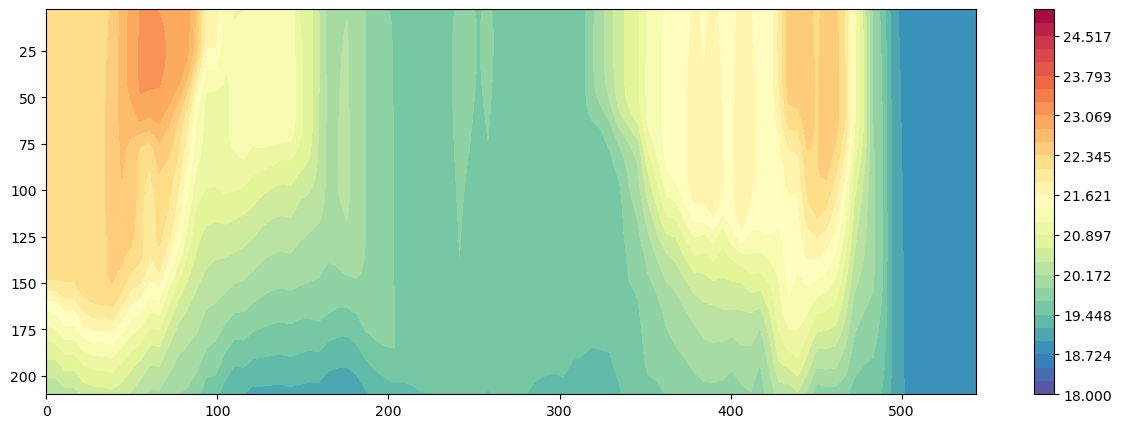

In [29]:
plt.figure(figsize=(15,5))
ax = plt.gca()
im = ax.contourf(dist, ocean.nz1_upper.values, oc_data, 
                 levels=np.linspace(18,25,30), 
                 cmap=cm.Spectral_r)
ax.invert_yaxis()
plt.colorbar(im)

Our atmospheric data are 6h, somehow hidden in 1h data, so to get right times we should do:

In [31]:
ds['q'][6:50:6,:,:].time

<xarray.DataArray 'time' (time: 8)>
array(['2020-01-20T06:00:00.000000000', '2020-01-20T12:00:00.000000000',
       '2020-01-20T18:00:00.000000000', '2020-01-21T00:00:00.000000000',
       '2020-01-21T06:00:00.000000000', '2020-01-21T12:00:00.000000000',
       '2020-01-21T18:00:00.000000000', '2020-01-22T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T06:00:00 ... 2020-01-22

For the ocean we have 3h data, and in FESOM timestep is set to be one time step before the end of averaging period:

In [33]:
ocean['temp_upper'][1:10:2,:,:].time

<xarray.DataArray 'time' (time: 5)>
array(['2020-01-20T05:56:00.000000000', '2020-01-20T11:56:00.000000000',
       '2020-01-20T17:56:00.000000000', '2020-01-20T23:56:00.000000000',
       '2020-01-21T05:56:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T05:56:00 ... 2020-01-21T05:56:00
Attributes:
    long_name:         time
    standard_name:     time
    axis:              T
    stored_direction:  increasing

Text(0.5, 0.98, 'Common title for the figure')

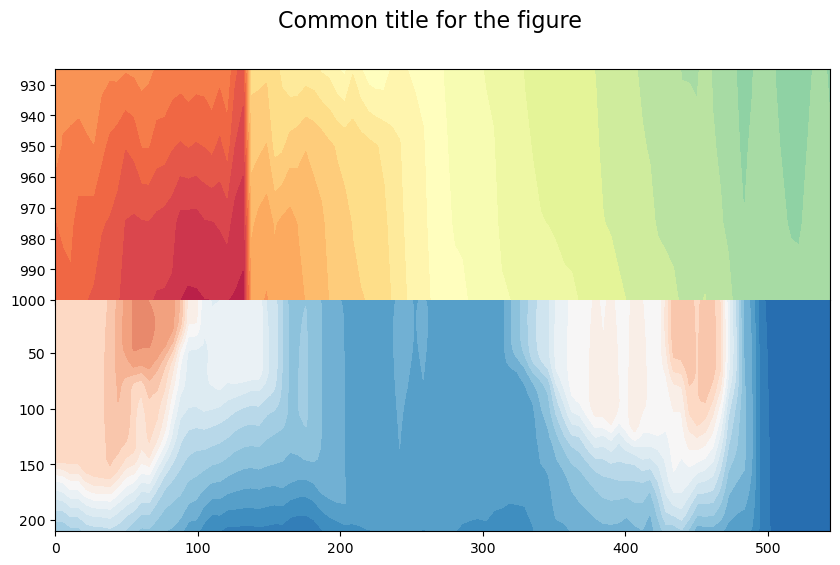

In [35]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
axs[0].contourf(dist, ds['t'].level.values[8:], as_data[8:,:], 
                 levels=np.linspace(0,0.014,30), 
                 cmap=cm.Spectral_r)
axs[0].invert_yaxis()
axs[0].spines['bottom'].set_visible(False)
axs[1].contourf(dist, ocean.nz1_upper.values, oc_data, 
                 levels=np.linspace(18,25,30), 
                 cmap=cm.RdBu_r)
axs[1].invert_yaxis()
axs[1].spines['top'].set_visible(False)
# remove vertical gap between subplots
plt.subplots_adjust(hspace=0)
fig.suptitle('Common title for the figure', fontsize=16)

In [ ]:
for i in range(0,500):
    as_time = 6*i
    os_time = 2*i
    a = ds['q'][6+as_time,:,:].values[:, nodes]    
    b = ocean['temp_upper'][1+os_time,:,:].values[:,nodes_ocean]
    # print(f"as_time {ds['t'][6+as_time,:,:].time}")
    # print(f"os_time {ocean['temp_upper'][1+os_time,:,:].time}")
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
    axs[0].contourf(dist, ds['t'].level.values[8:], a[8:,:], 
                     levels=np.linspace(0,0.020,30), 
                     cmap=cm.Spectral_r)
    axs[0].invert_yaxis()
    axs[0].spines['bottom'].set_visible(False)
    axs[1].contourf(dist, ocean.nz1_upper.values, b, 
                     levels=np.linspace(18,25,30), 
                     cmap=cm.RdBu_r)
    axs[1].invert_yaxis()
    axs[1].spines['top'].set_visible(False)
    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=0)
    fig.suptitle(f"{np.datetime_as_string(ds['t'][6+as_time,:,:].time.values)[:16]}", fontsize=12)
    plt.savefig(f'/work/ab0995/a270088/NextGems/Cycle3/movies/oldcouple2/{str(i).zfill(5)}.png')
    plt.close(fig)
    print(i)